# 1. Import and setup

In [137]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import pearsonr, ttest_ind
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [138]:
# Setting up styling
sns.set(style="darkgrid")
sns.set_palette("flare")

print(sns.color_palette("flare").as_hex())
palette = sns.color_palette("flare").as_hex()
sns.color_palette("flare")

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']


[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [139]:
RANDOM_STATE=42

In [140]:
# Helper function

"""
Plots histogram and boxplot to compare difference in distribution of given label
- label: the feature to be compared
- title: title of the figure
"""
def plot_mean_difference(df, label, title, colours, features_kde):
    fig, axes = plt.subplots(2, len(features_kde), figsize=(30, 7))
    value = df[label].unique()
    p_vals = []

    for i in range(len(features_kde)):
        feature = features_kde[i]
        for j, val in enumerate(df[label].unique()):
            sns.kdeplot(df[df[label] == val][feature], ax=axes[0, i], fill=True, label=val, color=colours[j])
        axes[0, i].set(ylabel=None)
        axes[0, i].set(xlabel=None)
        axes[0, i].set_title(feature)

        sns.boxplot(ax=axes[1, i], x=label, y=feature, data=df, palette=colours)
        axes[1, i].set(ylabel=None)
        axes[1, i].set(xlabel=None)
        
        t_statistic, p_value = ttest_ind(df[df[label] == value[0]][feature].dropna(),
                                 df[df[label] == value[1]][feature].dropna())
        p_vals.append(p_value)
    axes[0,-1].legend(title=label)

    fig.suptitle(title)
    plt.show()
    return dict(zip(features_kde, p_vals))

"""
Plot coefficient correlation inside a pair plot, used in pair_plot function
"""
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    marker_size = abs(r) * 10000
    ax.scatter([.5], [.5], marker_size, [r], alpha=0.6, cmap="flare",
            vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

"""
Plot pair grid of bivariate analysis, includes scatter plot and correlation computation
- df: dataframe containing all features
- label: the feature to be compared
- title: title of figure
"""
def pair_plot(df, label, title, colours):
    g = sns.PairGrid(df, hue=label, diag_sharey=False, palette=colours)
    g.map_upper(reg_coef, hue=None)
    g.map_diag(sns.kdeplot, fill=True)
    g.map_lower(sns.scatterplot)

    g.add_legend(adjust_subtitles=True, title=label)
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title)

    plt.show()

# 2. Read dataset

In [141]:
df = pd.read_csv('../dataset/icd_final_27th_Oct.csv', index_col=0)
df.head()

,hadm_id,alcoholism,gender,anchor_age,deathtime,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,...,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,23260768,0,F,60,NaN,21.9,24.0,1.2,142.0,75.0,...,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5
1,23059383,0,F,72,2147-11-06T18:30:00,34.3,29.0,1.3,55.0,32.0,...,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0
2,20779074,0,F,88,NaN,33.6,18.0,1.1,130.0,62.0,...,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7
3,20772091,0,M,34,2179-02-25T16:08:00,30.7,13.0,0.5,112.0,66.0,...,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0
4,21453368,0,F,38,2133-04-05T10:20:00,25.7,24.0,0.9,176.0,106.0,...,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0


In [142]:
# Label mortality
df['mortality'] = df['deathtime'].apply(lambda x: 'Survive' if x is np.nan else 'Dead')
df['mortality'].value_counts()

mortality
Survive    373
Dead        81
Name: count, dtype: int64

In [143]:
df.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime',
       'hematocrit_serum', 'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'lipase', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

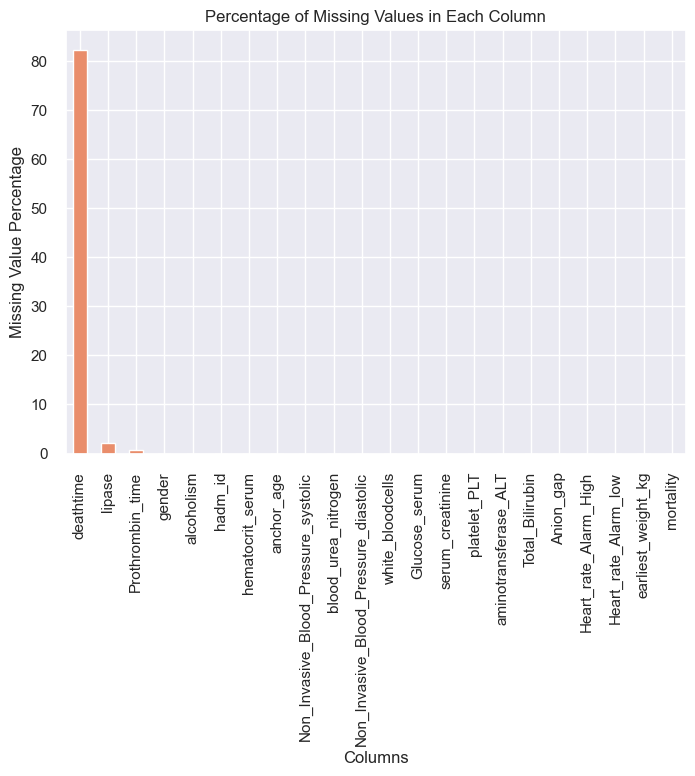

In [144]:
# Datatype and missing value information
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
    
missing_percentage.sort_values(ascending=False).plot(kind='bar', color=palette[0])
plt.xlabel('Columns')
plt.ylabel('Missing Value Percentage')
plt.title('Percentage of Missing Values in Each Column')
plt.show()

In [145]:
missing_columns = missing_percentage.sort_values(ascending=False)[:1]
missing_columns

deathtime    82.15859
dtype: float64

In [231]:
df_clean = df.drop(missing_columns.index, axis=1)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,...,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality
0,23260768,0,F,60,21.9,24.0,1.2,142.0,75.0,171.0,...,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5,Survive
1,23059383,0,F,72,34.3,29.0,1.3,55.0,32.0,10.0,...,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0,Dead
2,20779074,0,F,88,33.6,18.0,1.1,130.0,62.0,353.0,...,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7,Survive
3,20772091,0,M,34,30.7,13.0,0.5,112.0,66.0,NaN,...,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0,Dead
4,21453368,0,F,38,25.7,24.0,0.9,176.0,106.0,113.0,...,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0,Dead


In [232]:
(df_clean.isnull().sum(axis=1) / df_clean.shape[1]).value_counts().sort_index()

0.000000    441
0.047619     13
Name: count, dtype: int64

In [233]:
# Statistical description of numerical features
df_clean.describe(include=[np.number]).round(2)

,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,454.00,454.00,454.00,454.00,454.00,454.00,454.00,454.00,444.00,454.00,454.00,454.00,451.00,454.0,454.00,454.00,454.00,454.00,454.00
mean,24933999.80,0.22,58.60,33.83,29.54,1.66,128.64,73.23,603.17,13.88,159.63,227.47,17.16,226.8,2.77,16.19,124.06,54.46,84.62
std,2897739.39,0.41,17.23,7.17,25.10,1.71,26.53,19.98,945.91,8.83,126.40,140.31,9.44,798.9,5.23,5.57,10.69,8.10,23.20
min,20009550.00,0.00,22.00,16.00,3.00,0.10,55.00,12.00,5.00,0.10,35.00,10.00,8.80,2.0,0.10,5.00,50.00,20.00,32.00
25%,22386114.50,0.00,46.25,28.70,13.00,0.70,110.00,59.00,57.75,8.40,102.00,129.25,13.00,24.0,0.50,13.00,120.00,50.00,68.75
50%,25102125.00,0.00,57.50,33.00,22.00,1.10,127.00,71.50,210.00,12.05,126.00,199.50,14.40,51.0,1.00,15.00,120.00,50.00,80.50
75%,27559023.00,0.00,72.00,38.38,37.00,1.80,146.00,84.00,772.25,17.85,178.00,286.75,17.05,150.0,2.80,18.00,130.00,60.00,98.20
max,29966638.00,1.00,91.00,56.50,173.00,14.40,222.00,134.00,6095.00,77.80,1638.00,942.00,93.20,9582.0,46.50,49.00,180.00,135.00,168.20


In [234]:
# Statistical description of categorical features
df_clean.describe(include=[np.object_])

,gender,mortality
count,454,454
unique,2,2
top,M,Survive
freq,266,373


In [235]:
# Number of distinct patients
print('Number of distinct patients: ', df_clean.hadm_id.unique().shape[0])
print('Number of duplication', len(df_clean[df_clean.duplicated()]))

Number of distinct patients:  454
Number of duplication 0


In [236]:
df_clean.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'lipase', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

In [237]:
features_kde = ['hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg']

# 4. Preprocessing

In [238]:
# Drop gender
X = df_clean.drop(['hadm_id', 'gender', 'mortality'], axis=1)
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,0,60,21.9,24.0,1.2,142.0,75.0,171.0,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5
1,0,72,34.3,29.0,1.3,55.0,32.0,10.0,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0
2,0,88,33.6,18.0,1.1,130.0,62.0,353.0,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7
3,0,34,30.7,13.0,0.5,112.0,66.0,NaN,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0
4,0,38,25.7,24.0,0.9,176.0,106.0,113.0,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0


In [239]:
X['gender'] = LabelEncoder().fit_transform(df_clean['gender'])
# X['mortality'] = LabelEncoder().fit_transform(df_clean['mortality'])
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,gender
0,0,60,21.9,24.0,1.2,142.0,75.0,171.0,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5,0
1,0,72,34.3,29.0,1.3,55.0,32.0,10.0,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0,0
2,0,88,33.6,18.0,1.1,130.0,62.0,353.0,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7,0
3,0,34,30.7,13.0,0.5,112.0,66.0,NaN,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0,1
4,0,38,25.7,24.0,0.9,176.0,106.0,113.0,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0,0


In [240]:
X = X.fillna(X.median())

In [241]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.5280845 ,  0.08150007, -1.66555332, ..., -0.55106937,
        -1.04050685, -1.18949301],
       [-0.5280845 ,  0.77853677,  0.06498431, ..., -0.55106937,
        -0.84635974, -1.18949301],
       [-0.5280845 ,  1.70791903, -0.03270733, ..., -0.55106937,
        -1.07502189, -1.18949301],
       ...,
       [-0.5280845 ,  0.48810481, -0.11644302, ...,  0.68441456,
         0.43932554,  0.84069431],
       [-0.5280845 ,  0.83662316, -0.70259287, ...,  0.68441456,
        -0.77301528,  0.84069431],
       [-0.5280845 ,  1.01088233,  0.05102836, ...,  0.68441456,
        -0.54435313,  0.84069431]])

One of the feature of standard scaling is that, we can detect outliers by filtering values `abs(x) > 3.5`. We choose number `3.5` as it does not discard huge amount of data while still being reasonable number for an outlier.

In [242]:
# Outliers detection for each features
X_cleaned = pd.DataFrame(X_scaled)
X_cleaned = X_scaled[(np.abs(X_scaled) < 3.5).all(axis=1)]
df_clean = df_clean[(np.abs(X_scaled) < 3.5).all(axis=1)].reset_index(drop=True)
X = X[(np.abs(X_scaled) < 3.5).all(axis=1)]
print("Number of cleaned record is", len(X_cleaned))
X_cleaned

Number of cleaned record is 394


array([[-0.5280845 ,  0.08150007, -1.66555332, ..., -0.55106937,
        -1.04050685, -1.18949301],
       [-0.5280845 ,  0.77853677,  0.06498431, ..., -0.55106937,
        -0.84635974, -1.18949301],
       [-0.5280845 ,  1.70791903, -0.03270733, ..., -0.55106937,
        -1.07502189, -1.18949301],
       ...,
       [-0.5280845 , -0.8478822 ,  0.06498431, ...,  0.68441456,
         0.32715165,  0.84069431],
       [-0.5280845 ,  0.48810481, -0.11644302, ...,  0.68441456,
         0.43932554,  0.84069431],
       [-0.5280845 ,  1.01088233,  0.05102836, ...,  0.68441456,
        -0.54435313,  0.84069431]])

In [243]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_cleaned)

# Create a DataFrame for visualization
X_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
X_pca

,PC1,PC2,PC3
0,0.553259,-1.931454,-1.127561
1,3.259870,-0.581289,0.445974
2,1.431468,-0.799186,-1.623911
3,-0.601276,-1.783601,0.745202
4,-1.471712,-0.746101,-0.636753
...,...,...,...
389,1.064962,-0.431380,-1.244695
390,-1.335006,-0.055057,2.635543
391,-1.270176,0.566190,-0.261520
392,-0.514453,-0.111939,0.059268


# 5. K-Means


## 5.1. Finding optimal cluster

#### Manual

In [244]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_cleaned)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_cleaned, kmeans.labels_)
    ss.append(sil_score)

In [245]:
total_var = np.sum(np.var(X, axis=0)) * X.shape[0]
total_var

232709760.74776646

In [246]:
var_explained = (1 - (np.array(wcss) / np.sum(wcss))) * 100
var_explained

array([90.17632981, 90.81800133, 91.41130249, 91.83586148, 92.16398922,
       92.37508929, 92.58484422, 92.75298003, 92.92342194, 93.09721969,
       93.20707406, 93.26050722, 93.39337923])

Text(0.5, 1.0, 'Total Variance Explained')

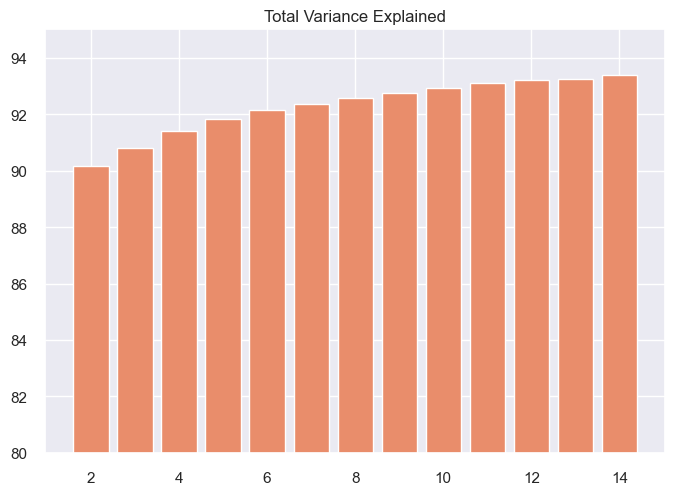

In [247]:
plt.bar(range(2,15), var_explained)
plt.ylim((80,95))
plt.title("Total Variance Explained")

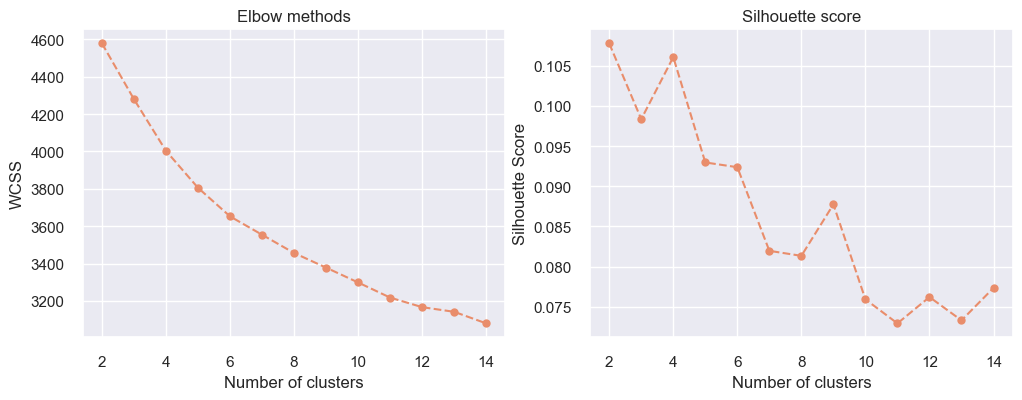

In [248]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.show()

#### On Yellowbrick

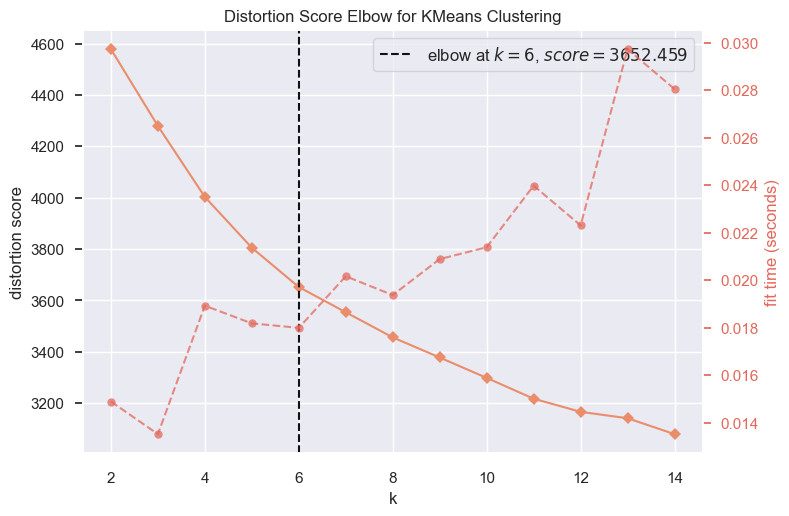

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [249]:
model = KMeans(random_state=RANDOM_STATE)
visualizer = KElbowVisualizer(model, k=(2,15))
# Fit and show the performance with dataset
visualizer.fit(X_cleaned)
visualizer.show()

In [250]:
kmeans_cluster = 6

## 5.2. Fitting the model

In [251]:
# Fit model
kmeans = KMeans(n_clusters=kmeans_cluster, random_state=RANDOM_STATE)
kmeans.fit(X_cleaned)

df_clean['cluster'] = kmeans.labels_.astype(object)
X_pca['cluster'] = df_clean['cluster']
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality,cluster
0,23260768,0,F,60,21.9,24.0,1.2,142.0,75.0,171.0,...,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5,Survive,0
1,23059383,0,F,72,34.3,29.0,1.3,55.0,32.0,10.0,...,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0,Dead,5
2,20779074,0,F,88,33.6,18.0,1.1,130.0,62.0,353.0,...,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7,Survive,5
3,20772091,0,M,34,30.7,13.0,0.5,112.0,66.0,NaN,...,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0,Dead,0
4,21453368,0,F,38,25.7,24.0,0.9,176.0,106.0,113.0,...,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0,Dead,0


In [252]:
# Evaluation metric
wcss = kmeans.inertia_
ss = silhouette_score(X_cleaned, kmeans.labels_)

print(f"Fitting model with {kmeans_cluster} clusters, resulting on {round(wcss,2)} WCSS and {round(ss,2)} silhouette score")

Fitting model with 6 clusters, resulting on 3652.46 WCSS and 0.09 silhouette score


In [168]:
# Center of clusters
kmeans_center = scaler.inverse_transform(kmeans.cluster_centers_)
pd.DataFrame(dict(zip(df_clean.columns, kmeans_center.T)))

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low
0,8.326673e-17,43.563636,30.770909,13.836364,0.747273,132.654545,80.254545,231.690909,13.029091,126.490909,344.363636,15.632727,90.436364,1.261818,13.836364,127.363636,53.727273,75.269091,2.727273e-01
1,1.000000e+00,46.959459,34.050000,16.594595,1.009459,132.756757,82.824324,444.216216,12.048649,155.202703,225.716216,14.335135,172.202703,2.516216,15.297297,124.189189,55.000000,83.343243,7.027027e-01
2,-8.326673e-17,65.391304,32.669565,24.902174,1.258696,116.956522,63.956522,398.782609,11.825000,139.076087,204.358696,17.197826,166.956522,2.246739,14.195652,121.739130,54.239130,91.181522,9.782609e-01
3,1.764706e-01,61.117647,33.711765,69.588235,4.588235,116.058824,60.058824,722.088235,13.829412,166.735294,182.147059,16.214706,180.382353,2.779412,21.735294,122.205882,53.088235,86.626471,6.470588e-01
4,3.278689e-02,55.098361,41.465574,25.032787,1.232787,156.754098,94.344262,731.885246,16.062295,171.639344,200.704918,15.344262,146.409836,2.296721,16.655738,124.754098,54.016393,94.939344,8.196721e-01
5,1.282051e-02,75.076923,32.146154,29.500000,1.305128,119.333333,61.525641,528.320513,14.162821,139.705128,206.846154,16.253846,163.782051,2.129487,14.743590,123.525641,52.435897,74.398718,-2.220446e-16


# 5. DBSCAN

In [180]:
# Applying DBScan
dbscan = DBSCAN(eps=3)
clusters = dbscan.fit_predict(X_cleaned)

df_clean['DB_cluster'] = clusters
X_pca['DB_cluster'] = clusters
df_clean['DB_cluster'].value_counts()

DB_cluster
 0    303
-1     91
Name: count, dtype: int64

In [184]:
db_cluster = 2

# K-Prototypes

In [185]:
# Drop gender
X2 = df_clean.drop(['hadm_id', 'gender', 'mortality', 'alcoholism', 'cluster', 'DB_cluster'], axis=1)
X2 = X2.fillna(X2.median())
X2.head()

,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,60,21.9,24.0,1.2,142.0,75.0,171.0,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5
1,72,34.3,29.0,1.3,55.0,32.0,10.0,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0
2,88,33.6,18.0,1.1,130.0,62.0,353.0,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7
3,34,30.7,13.0,0.5,112.0,66.0,183.0,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0
4,38,25.7,24.0,0.9,176.0,106.0,113.0,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0


In [186]:
scaler2 = StandardScaler()
X_scaled2 = scaler2.fit_transform(X2)
X_scaled2

array([[ 0.06697982, -1.69404635, -0.12587991, ..., -0.44400621,
        -0.74794902, -1.05619678],
       [ 0.75842213,  0.04029133,  0.11771874, ...,  0.71070301,
        -0.74794902, -0.85695041],
       [ 1.68034521, -0.05761483, -0.4181983 , ...,  0.71070301,
        -0.74794902, -1.09161836],
       ...,
       [-0.85494326,  0.04029133,  0.41003712, ..., -0.44400621,
         1.21013679,  0.34738317],
       [ 0.47032116, -0.14153439, -0.46691803, ..., -0.44400621,
         1.21013679,  0.46250329],
       [ 0.9889029 ,  0.02630474,  0.70235551, ...,  0.71070301,
         1.21013679, -0.54701162]])

In [187]:
X_scaled2 = np.c_[X_scaled2, X['gender'], X['alcoholism']]

In [196]:
costs = []
n_clusters = []
ss = []

for i in range(2, 15):
    kproto = KPrototypes(n_clusters=i, random_state=RANDOM_STATE)
    clusters = kproto.fit_predict(X_scaled2, categorical=[17,18])
    
    costs.append(kproto.cost_)
    n_clusters.append(i)

    # Record silhouette score
    sil_score = silhouette_score(X_scaled2, clusters)
    ss.append(sil_score)

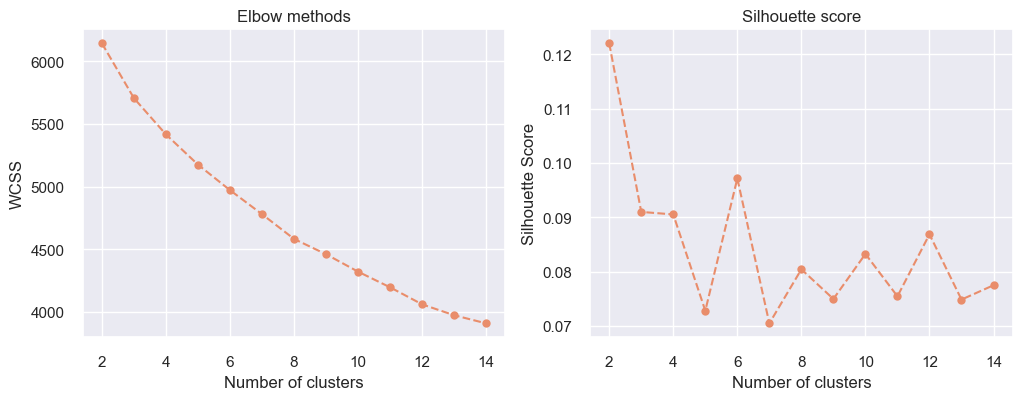

In [198]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), costs, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.show()

In [199]:
proto_cluster = 6

In [203]:
kproto = KPrototypes(n_clusters=proto_cluster, random_state=RANDOM_STATE)
df_clean['proto_cluster'] = kproto.fit_predict(X_scaled2, categorical=[17,18])
X_pca['proto_cluster'] = df_clean['proto_cluster']

In [204]:
X2.shape

(394, 17)

In [205]:
kproto._enc_cluster_centroids[1]

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 0]], dtype=object)

In [206]:
scaler2.inverse_transform(kproto._enc_cluster_centroids[0])

array([[6.77272727e+01, 3.45800000e+01, 6.42000000e+01, 3.62545455e+00,
        1.25163636e+02, 6.42000000e+01, 5.84800000e+02, 1.39454545e+01,
        1.73581818e+02, 1.86472727e+02, 1.57781818e+01, 1.03636364e+02,
        1.46000000e+00, 1.93454545e+01, 1.22000000e+02, 5.37272727e+01,
        8.83781818e+01],
       [4.93421053e+01, 3.42657895e+01, 1.84210526e+01, 9.97368421e-01,
        1.32315789e+02, 8.13157895e+01, 5.03210526e+02, 1.34631579e+01,
        1.48105263e+02, 2.98052632e+02, 1.43736842e+01, 7.11315789e+01,
        1.37894737e+00, 1.46842105e+01, 1.43684211e+02, 5.43421053e+01,
        8.57315789e+01],
       [5.65454545e+01, 3.09454545e+01, 3.11818182e+01, 2.14545455e+00,
        1.14272727e+02, 6.54545455e+01, 8.13000000e+02, 1.05363636e+01,
        1.21818182e+02, 1.16454545e+02, 2.26909091e+01, 1.74945455e+03,
        4.47272727e+00, 1.98181818e+01, 1.24545455e+02, 5.31818182e+01,
        8.06181818e+01],
       [6.13607595e+01, 3.14670886e+01, 1.96835443e+01, 9.727

In [207]:
pd.DataFrame(np.c_[scaler2.inverse_transform(kproto._enc_cluster_centroids[0]), kproto._enc_cluster_centroids[1]],
            columns=list(X2.columns)+['gender', 'alcoholism'])

,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,gender,alcoholism
0,67.727273,34.58,64.2,3.625455,125.163636,64.2,584.8,13.945455,173.581818,186.472727,15.778182,103.636364,1.46,19.345455,122.0,53.727273,88.378182,1,0
1,49.342105,34.265789,18.421053,0.997368,132.315789,81.315789,503.210526,13.463158,148.105263,298.052632,14.373684,71.131579,1.378947,14.684211,143.684211,54.342105,85.731579,1,0
2,56.545455,30.945455,31.181818,2.145455,114.272727,65.454545,813.0,10.536364,121.818182,116.454545,22.690909,1749.454545,4.472727,19.818182,124.545455,53.181818,80.618182,1,0
3,61.360759,31.467089,19.683544,0.972785,118.303797,66.632911,317.917722,11.905063,126.873418,243.810127,14.503165,110.78481,1.590506,13.443038,121.234177,53.259494,77.090506,0,0
4,51.945055,39.227473,19.120879,1.014286,152.076923,92.549451,683.43956,15.223077,182.197802,225.516484,13.940659,113.32967,1.552747,16.076923,122.252747,55.879121,90.695604,1,0
5,61.902439,32.068293,25.609756,1.407317,121.853659,66.634146,484.536585,14.390244,125.170732,173.341463,25.217073,132.97561,7.036585,16.512195,121.341463,51.219512,92.6,1,0


# Result

In [208]:
def stat_cum(cluster, clusters):
    cluster0 = df_clean[clusters == cluster]
    mort_rate = round(100* len(cluster0[cluster0.mortality == 'Dead']) / len(cluster0),2)
    print(f"Percentage of women and men (respectively) {round(100 * sum(cluster0.gender == 'F') / len(cluster0),2)} and {round(100 * sum(cluster0.gender == 'M') / len(cluster0),2)}")
    print(f"Mortality rate is {mort_rate}")
    display(round(cluster0.describe(),2))
    return cluster0.describe().loc['mean',:], mort_rate

## Value Counts

In [209]:
df_clean['cluster'].value_counts()

cluster
2    92
5    78
1    74
4    61
0    55
3    34
Name: count, dtype: int64

In [210]:
df_clean['DB_cluster'].value_counts()

DB_cluster
 0    303
-1     91
Name: count, dtype: int64

In [211]:
df_clean['proto_cluster'].value_counts()

proto_cluster
3    158
4     91
0     55
5     41
1     38
2     11
Name: count, dtype: int64

## Statistics

In [212]:
stats = pd.DataFrame(index=list(df_clean.columns) + ['mortality_rate'],
                     columns=[])

In [213]:
for i in range(kmeans_cluster):
    print("====================== Cluster %s =========================" % (i))
    kmeans_result, mort_rate = stat_cum(i, df_clean.cluster)
    stats["Kmeans" + str(i)] = 0
    stats.loc[kmeans_result.index, "Kmeans" + str(i)] = kmeans_result.values
    stats.loc['mortality_rate', "Kmeans" + str(i)] = mort_rate

====================== Cluster 0 =========================
Percentage of women and men (respectively) 72.73 and 27.27
Mortality rate is 9.09


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,55.00,55.0,55.00,55.00,55.00,55.00,55.00,55.00,53.00,55.00,...,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00
mean,24561596.65,0.0,43.56,30.77,13.84,0.75,132.65,80.25,232.51,13.03,...,344.36,15.63,90.44,1.26,13.84,127.36,53.73,75.27,-0.15,2.69
std,3008865.31,0.0,11.56,4.85,8.18,0.53,22.63,15.89,408.28,7.81,...,158.13,5.41,169.87,1.90,3.73,12.09,4.83,21.49,0.36,1.12
min,20079585.00,0.0,22.00,21.30,3.00,0.20,88.00,51.00,6.00,0.10,...,41.00,9.40,4.00,0.10,5.00,100.00,50.00,32.00,-1.00,1.00
25%,21749371.00,0.0,33.50,27.75,8.00,0.50,114.00,70.00,44.00,7.20,...,225.00,13.20,19.50,0.40,12.00,120.00,50.00,61.95,0.00,1.50
50%,24953604.00,0.0,45.00,29.70,11.00,0.60,133.00,80.00,112.00,11.60,...,333.00,14.10,35.00,0.60,14.00,120.00,50.00,70.00,0.00,3.00
75%,26932715.50,0.0,51.00,32.95,18.50,0.80,149.00,90.50,189.00,16.40,...,460.00,16.85,90.50,1.00,16.00,130.00,60.00,86.40,0.00,3.00
max,29790328.00,0.0,66.00,42.20,50.00,3.40,188.00,133.00,2596.00,41.50,...,687.00,45.50,1135.00,11.30,30.00,160.00,60.00,147.30,0.00,5.00


====================== Cluster 1 =========================
Percentage of women and men (respectively) 29.73 and 70.27
Mortality rate is 5.41


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,74.00,74.0,74.00,74.00,74.00,74.00,74.00,74.00,74.00,74.00,...,74.00,73.00,74.00,74.00,74.00,74.00,74.0,74.00,74.00,74.00
mean,25423084.23,1.0,46.96,34.05,16.59,1.01,132.76,82.82,444.22,12.05,...,225.72,14.33,172.20,2.52,15.30,124.19,55.0,83.34,-0.22,3.19
std,2846754.62,0.0,10.53,6.65,10.48,0.68,23.92,19.03,620.33,6.21,...,159.39,3.80,376.65,3.52,5.15,7.59,5.3,20.69,0.41,1.21
min,20561449.00,1.0,25.00,20.70,3.00,0.20,73.00,39.00,13.00,2.50,...,28.00,8.80,9.00,0.20,5.00,120.00,40.0,45.40,-1.00,0.00
25%,23296515.25,1.0,40.00,29.35,8.00,0.52,115.00,69.75,67.00,7.35,...,109.00,12.40,22.00,0.60,12.00,120.00,50.0,69.00,0.00,3.00
50%,25362069.50,1.0,46.50,33.30,13.50,0.80,131.50,80.00,190.00,10.85,...,184.50,13.20,41.00,1.30,14.00,120.00,60.0,78.95,0.00,3.00
75%,27991423.75,1.0,55.00,38.35,23.75,1.20,150.75,95.75,491.00,15.82,...,282.75,15.10,113.00,2.95,17.00,130.00,60.0,98.05,0.00,4.00
max,29961750.00,1.0,68.00,47.30,51.00,4.10,189.00,134.00,2808.00,33.90,...,690.00,34.20,2095.00,17.90,34.00,150.00,60.0,150.00,0.00,5.00


====================== Cluster 2 =========================
Percentage of women and men (respectively) 2.17 and 97.83
Mortality rate is 14.13


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,92.00,92.0,92.00,92.00,92.00,92.00,92.00,92.00,91.00,92.00,...,92.00,92.00,92.00,92.00,92.0,92.00,92.00,92.00,92.00,92.00
mean,24683096.48,0.0,65.39,32.67,24.90,1.26,116.96,63.96,400.86,11.82,...,204.36,17.20,166.96,2.25,14.2,121.74,54.24,91.18,-0.11,2.98
std,2842790.79,0.0,14.82,6.56,13.26,0.59,22.54,12.07,623.98,6.42,...,98.28,6.83,412.37,2.32,3.5,7.79,5.59,24.67,0.31,1.49
min,20178091.00,0.0,31.00,17.70,6.00,0.30,68.00,37.00,5.00,0.10,...,17.00,10.00,2.00,0.10,7.0,100.00,30.00,40.00,-1.00,0.00
25%,22316757.25,0.0,54.00,27.62,15.00,0.80,100.00,56.00,32.00,7.30,...,147.75,13.38,23.75,0.60,12.0,120.00,50.00,72.00,0.00,3.00
50%,24549694.00,0.0,65.50,32.95,22.00,1.20,115.00,65.50,111.00,10.05,...,184.50,14.85,45.00,1.35,14.0,120.00,50.00,85.90,0.00,3.00
75%,27057443.50,0.0,78.00,37.12,32.00,1.60,134.25,73.00,563.50,16.88,...,248.75,17.70,133.50,3.22,16.0,120.00,60.00,103.50,0.00,4.00
max,29956550.00,0.0,91.00,47.70,72.00,3.10,191.00,91.00,3705.00,28.20,...,479.00,47.80,2976.00,9.90,28.0,150.00,60.00,165.60,0.00,5.00


====================== Cluster 3 =========================
Percentage of women and men (respectively) 35.29 and 64.71
Mortality rate is 32.35


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,...,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00,34.00
mean,25030637.68,0.18,61.12,33.71,69.59,4.59,116.06,60.06,722.09,13.83,...,182.15,16.21,180.38,2.78,21.74,122.21,53.09,86.63,-0.76,0.41
std,3108069.28,0.39,13.86,8.10,22.12,1.33,21.43,13.04,801.58,9.35,...,113.22,4.95,342.75,4.00,6.51,5.93,4.61,21.09,0.43,1.26
min,20009550.00,0.00,31.00,21.50,39.00,2.50,75.00,39.00,8.00,2.40,...,32.00,11.10,6.00,0.10,13.00,120.00,50.00,47.10,-1.00,0.00
25%,22371473.75,0.00,52.00,28.52,53.00,3.70,102.00,50.50,101.50,7.48,...,104.25,13.62,23.00,0.40,17.00,120.00,50.00,73.25,-1.00,0.00
50%,25231398.00,0.00,62.00,32.30,64.00,4.40,113.50,60.50,402.00,11.50,...,167.00,14.90,42.50,1.10,20.50,120.00,50.00,80.95,-1.00,0.00
75%,27955563.00,0.00,75.00,40.02,88.25,5.38,127.50,64.75,926.25,19.48,...,246.75,15.90,136.50,3.50,24.00,120.00,60.00,99.28,-1.00,0.00
max,29966638.00,1.00,82.00,51.30,110.00,7.60,167.00,110.00,3187.00,42.80,...,475.00,30.90,1624.00,17.10,35.00,150.00,60.00,124.00,0.00,5.00


====================== Cluster 4 =========================
Percentage of women and men (respectively) 18.03 and 81.97
Mortality rate is 14.75


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,60.00,61.00,...,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00
mean,24706226.82,0.03,55.10,41.47,25.03,1.23,156.75,94.34,740.58,16.06,...,200.70,15.34,146.41,2.30,16.66,124.75,54.02,94.94,-0.31,3.52
std,3019962.03,0.18,16.63,7.02,16.05,0.71,20.81,16.26,835.88,7.06,...,93.56,5.12,285.10,3.08,3.51,9.15,5.39,22.50,0.47,1.29
min,20024364.00,0.00,25.00,23.20,7.00,0.10,118.00,62.00,6.00,1.70,...,20.00,10.80,4.00,0.20,11.00,120.00,45.00,48.20,-1.00,0.00
25%,22183776.00,0.00,42.00,36.50,13.00,0.80,142.00,83.00,89.25,11.00,...,128.00,13.00,26.00,0.70,14.00,120.00,50.00,78.80,-1.00,4.00
50%,24336759.00,0.00,55.00,42.30,20.00,1.00,154.00,93.00,386.50,15.30,...,194.00,14.40,51.00,1.10,15.00,120.00,50.00,94.00,0.00,4.00
75%,27541056.00,0.00,69.00,46.70,33.00,1.50,167.00,104.00,1200.00,20.90,...,255.00,15.50,165.00,2.30,18.00,130.00,60.00,110.00,0.00,4.00
max,29468459.00,1.00,87.00,56.50,82.00,4.20,207.00,132.00,3515.00,32.80,...,400.00,42.60,2060.00,17.80,26.00,160.00,70.00,153.70,0.00,5.00


====================== Cluster 5 =========================
Percentage of women and men (respectively) 100.0 and 0.0
Mortality rate is 24.36


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,78.00,78.00,78.00,78.00,78.00,78.00,78.00,78.00,75.00,78.00,...,78.00,76.00,78.00,78.00,78.00,78.00,78.00,78.00,78.00,78.00
mean,25082083.94,0.01,75.08,32.15,29.50,1.31,119.33,61.53,541.05,14.16,...,206.85,16.30,163.78,2.13,14.74,123.53,52.44,74.40,-0.15,2.77
std,2924365.39,0.11,12.28,5.34,18.54,0.74,22.63,14.77,711.86,7.92,...,105.77,6.27,221.97,2.60,3.38,7.65,4.24,16.38,0.36,1.29
min,20101858.00,0.00,40.00,22.00,5.00,0.50,55.00,12.00,9.00,1.30,...,10.00,10.80,7.00,0.10,8.00,120.00,50.00,45.00,-1.00,0.00
25%,22497767.50,0.00,65.00,27.95,17.00,0.72,105.25,51.25,68.00,8.30,...,130.50,13.10,36.25,0.70,12.00,120.00,50.00,63.02,0.00,3.00
50%,25215039.00,0.00,76.00,31.75,24.50,1.10,116.00,62.00,223.00,12.70,...,200.00,14.30,83.00,1.20,14.00,120.00,50.00,74.70,0.00,3.00
75%,27628696.25,0.00,86.00,36.28,39.25,1.60,135.00,72.00,860.00,18.48,...,274.50,16.55,189.75,2.38,17.00,120.00,53.75,82.90,0.00,3.00
max,29903947.00,1.00,91.00,45.80,82.00,3.90,184.00,97.00,3516.00,38.20,...,570.00,45.30,1274.00,16.70,25.00,160.00,60.00,118.60,0.00,5.00


In [214]:
for i in range(-1,-1+db_cluster):
    print("====================== Cluster %s =========================" % (i))
    db_result, mort_rate = stat_cum(i, df_clean.DB_cluster)
    stats["DB" + str(i)] = 0
    stats.loc[db_result.index, "DB" + str(i)] = db_result.values
    stats.loc['mortality_rate', "DB" + str(i)] = mort_rate

====================== Cluster -1 =========================
Percentage of women and men (respectively) 45.05 and 54.95
Mortality rate is 24.18


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.00,89.00,91.00,...,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.0,91.00
mean,25317847.46,0.24,57.79,35.03,40.29,2.42,130.56,73.48,873.12,14.20,...,183.15,19.22,299.88,3.30,19.26,124.67,53.74,85.76,-1.0,2.34
std,3030648.44,0.43,18.39,8.10,27.44,1.79,31.41,24.27,947.92,9.11,...,132.46,8.97,548.21,4.62,6.34,10.82,5.66,24.02,0.0,2.05
min,20009550.00,0.00,25.00,20.70,3.00,0.40,73.00,12.00,16.00,0.70,...,18.00,8.80,10.00,0.10,8.00,100.00,30.00,47.40,-1.0,0.00
25%,22460205.50,0.00,45.00,28.55,18.50,1.00,105.00,56.00,160.00,7.45,...,83.00,13.80,31.50,0.50,15.00,120.00,50.00,69.00,-1.0,0.00
50%,25780991.00,0.00,59.00,34.30,37.00,2.00,129.00,69.00,407.00,12.50,...,136.00,15.40,60.00,1.20,18.00,120.00,50.00,79.10,-1.0,2.00
75%,28103648.00,0.00,70.50,41.15,55.00,3.30,150.50,84.50,1387.00,19.70,...,249.00,20.80,242.50,3.95,22.50,130.00,60.00,102.00,-1.0,4.00
max,29961750.00,1.00,91.00,54.30,110.00,7.60,207.00,134.00,3516.00,42.80,...,610.00,47.80,2976.00,17.90,35.00,160.00,70.00,163.30,-1.0,5.00


====================== Cluster 0 =========================
Percentage of women and men (respectively) 40.92 and 59.08
Mortality rate is 12.87


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,303.00,303.0,303.00,303.00,303.00,303.00,303.00,303.00,298.00,303.00,...,303.00,300.00,303.00,303.00,303.00,303.00,303.00,303.00,303.0,303.00
mean,24797494.62,0.2,59.15,33.71,22.47,1.14,128.10,73.72,380.97,13.07,...,238.77,14.89,110.98,1.86,14.36,123.60,53.84,83.93,0.0,2.94
std,2894958.74,0.4,17.08,6.84,15.86,0.80,24.55,18.17,538.84,6.78,...,129.24,3.67,188.13,2.00,3.29,7.92,4.95,22.20,0.0,1.28
min,20024364.00,0.0,22.00,17.70,3.00,0.10,55.00,26.00,5.00,0.10,...,10.00,9.40,2.00,0.10,5.00,100.00,40.00,32.00,0.0,0.00
25%,22339761.00,0.0,47.00,28.80,11.00,0.60,111.00,61.50,43.00,8.45,...,157.00,12.88,22.00,0.60,12.00,120.00,50.00,68.80,0.0,3.00
50%,24877202.00,0.0,58.00,33.10,18.00,0.90,126.00,73.00,143.00,12.00,...,215.00,14.10,44.00,0.90,14.00,120.00,50.00,81.20,0.0,3.00
75%,27286562.00,0.0,73.00,37.75,28.50,1.30,144.00,84.00,548.25,17.20,...,302.50,15.70,130.00,2.40,16.00,120.00,60.00,97.60,0.0,4.00
max,29966638.00,1.0,91.00,56.50,99.00,5.70,201.00,133.00,3705.00,32.80,...,690.00,45.10,1730.00,11.30,28.00,160.00,60.00,165.60,0.0,5.00


In [215]:
for i in range(proto_cluster):
    print("====================== Cluster %s =========================" % (i))
    proto_result, mort_rate = stat_cum(i, df_clean.proto_cluster)
    stats["Kproto" + str(i)] = 0
    stats.loc[proto_result.index, "Kproto" + str(i)] = proto_result.values
    stats.loc['mortality_rate', "Kproto" + str(i)] = mort_rate

====================== Cluster 0 =========================
Percentage of women and men (respectively) 34.55 and 65.45
Mortality rate is 29.09


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,...,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.00,55.0
mean,25184842.55,0.11,67.73,34.58,64.20,3.63,125.16,64.20,584.80,13.95,...,186.47,15.78,103.64,1.46,19.35,122.00,53.73,88.38,-0.55,0.0
std,3032250.30,0.31,14.13,7.63,20.48,1.59,23.85,15.16,727.64,8.98,...,102.37,4.91,148.97,1.51,5.65,6.43,4.83,22.57,0.50,0.0
min,20009550.00,0.00,31.00,21.50,33.00,1.40,75.00,39.00,8.00,2.40,...,10.00,10.80,6.00,0.10,12.00,100.00,50.00,47.10,-1.00,0.0
25%,22418823.50,0.00,57.00,28.85,48.00,2.35,109.50,53.50,79.50,7.65,...,119.00,13.10,22.50,0.40,15.50,120.00,50.00,73.70,-1.00,0.0
50%,25423329.00,0.00,70.00,32.60,58.00,3.20,124.00,63.00,249.00,10.90,...,168.00,14.30,40.00,0.90,18.00,120.00,50.00,83.70,-1.00,0.0
75%,27965243.00,0.00,79.00,40.35,79.00,4.65,139.50,72.50,776.00,19.35,...,236.00,15.90,89.00,1.85,21.50,120.00,60.00,101.80,0.00,0.0
max,29966638.00,1.00,91.00,51.70,110.00,7.60,207.00,110.00,3187.00,42.80,...,475.00,38.40,593.00,5.90,35.00,150.00,60.00,153.70,0.00,0.0


====================== Cluster 1 =========================
Percentage of women and men (respectively) 39.47 and 60.53
Mortality rate is 21.05


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,38.00,38.00,38.00,38.00,38.00,38.0,38.00,38.00,36.00,38.00,...,38.00,38.00,38.00,38.00,38.00,38.00,38.00,38.00,38.00,38.0
mean,24893127.11,0.24,49.34,34.27,18.42,1.0,132.32,81.32,521.00,13.46,...,298.05,14.37,71.13,1.38,14.68,143.68,54.34,85.73,-0.26,1.0
std,2688334.91,0.43,18.50,7.05,14.08,0.6,22.81,17.78,764.23,6.28,...,169.10,2.48,129.49,1.75,3.16,8.11,4.96,17.16,0.45,0.0
min,20672345.00,0.00,25.00,21.30,5.00,0.3,73.00,46.00,15.00,3.60,...,24.00,9.80,6.00,0.10,8.00,130.00,50.00,55.80,-1.00,1.0
25%,22927239.00,0.00,34.25,29.50,9.00,0.6,114.00,66.25,67.25,7.98,...,171.50,12.70,20.00,0.40,13.00,140.00,50.00,74.53,-0.75,1.0
50%,24204410.00,0.00,47.00,32.85,13.00,0.9,138.00,82.00,154.50,12.85,...,277.50,14.20,28.50,0.80,15.00,140.00,50.00,80.80,0.00,1.0
75%,27279655.00,0.00,57.75,37.83,23.00,1.2,149.75,93.00,722.00,16.60,...,440.75,15.20,44.00,1.50,16.75,150.00,60.00,96.15,0.00,1.0
max,29831372.00,1.00,91.00,54.30,69.00,3.1,174.00,133.00,2808.00,28.20,...,622.00,22.60,598.00,9.30,21.00,160.00,60.00,128.00,0.00,1.0


====================== Cluster 2 =========================
Percentage of women and men (respectively) 36.36 and 63.64
Mortality rate is 36.36


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,10.00,11.00,...,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.0
mean,25238302.09,0.36,56.55,30.95,31.18,2.15,114.27,65.45,876.00,10.54,...,116.45,22.69,1749.45,4.47,19.82,124.55,53.18,80.62,-0.82,2.0
std,3269176.52,0.50,19.78,6.17,12.06,1.17,30.39,18.44,858.67,7.66,...,86.09,6.07,531.89,4.07,7.39,12.74,4.62,19.87,0.40,0.0
min,20079585.00,0.00,25.00,23.20,14.00,0.90,81.00,39.00,21.00,0.10,...,17.00,13.80,1083.00,0.80,9.00,100.00,50.00,47.40,-1.00,2.0
25%,23440912.50,0.00,44.50,25.75,21.50,1.20,96.50,51.00,159.25,5.75,...,59.50,17.55,1436.00,1.55,14.50,120.00,50.00,70.85,-1.00,2.0
50%,24510713.00,0.00,59.00,31.60,33.00,1.70,105.00,66.00,820.50,7.80,...,84.00,23.00,1730.00,3.40,19.00,120.00,50.00,77.10,-1.00,2.0
75%,27892754.00,1.00,63.50,33.40,37.00,3.05,128.50,79.00,1117.75,16.30,...,169.50,27.55,1978.00,5.45,25.00,132.50,57.50,87.50,-1.00,2.0
max,29550274.00,1.00,91.00,43.40,56.00,4.20,185.00,100.00,2596.00,23.60,...,283.00,33.20,2976.00,13.10,35.00,150.00,60.00,125.00,0.00,2.0


====================== Cluster 3 =========================
Percentage of women and men (respectively) 56.33 and 43.67
Mortality rate is 10.76


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,158.00,158.00,158.00,158.00,158.00,158.00,158.00,158.00,156.00,158.00,...,158.00,156.00,158.00,158.00,158.00,158.00,158.00,158.00,158.00,158.0
mean,24797624.77,0.16,61.36,31.47,19.68,0.97,118.30,66.63,319.65,11.91,...,243.81,14.51,110.78,1.59,13.44,121.23,53.26,77.09,-0.02,3.0
std,2919252.05,0.37,17.11,5.31,11.02,0.54,20.44,14.01,463.24,6.42,...,130.72,2.68,160.31,1.60,3.11,4.54,4.82,19.18,0.14,0.0
min,20101858.00,0.00,22.00,17.70,3.00,0.20,55.00,26.00,5.00,0.10,...,17.00,9.40,2.00,0.10,5.00,100.00,40.00,32.00,-1.00,3.0
25%,22291355.25,0.00,48.25,27.82,11.00,0.60,106.00,58.00,36.00,7.12,...,162.25,12.80,22.25,0.50,11.25,120.00,50.00,63.52,0.00,3.0
50%,25102125.00,0.00,60.50,30.95,18.00,0.90,116.50,67.50,134.00,10.65,...,223.50,13.95,43.50,0.90,13.00,120.00,50.00,74.30,0.00,3.0
75%,27191059.00,0.00,74.75,34.88,25.00,1.20,133.00,76.75,409.50,15.85,...,307.00,15.15,135.75,2.15,15.00,120.00,60.00,88.88,0.00,3.0
max,29956550.00,1.00,91.00,45.80,62.00,3.20,185.00,97.00,3165.00,32.10,...,690.00,27.00,879.00,7.70,28.00,140.00,60.00,131.00,0.00,3.0


====================== Cluster 4 =========================
Percentage of women and men (respectively) 27.47 and 72.53
Mortality rate is 8.79


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.00,89.00,91.00,...,91.00,90.00,91.00,91.00,91.00,91.00,91.00,91.00,91.00,91.0
mean,24873743.03,0.34,51.95,39.23,19.12,1.01,152.08,92.55,694.69,15.22,...,225.52,13.94,113.33,1.55,16.08,122.25,55.88,90.70,-0.21,4.0
std,3052105.74,0.48,13.79,7.17,10.22,0.49,21.73,18.02,888.09,7.68,...,129.46,2.74,152.37,1.49,4.51,5.44,5.25,25.26,0.41,0.0
min,20024364.00,0.00,25.00,25.10,3.00,0.10,100.00,51.00,6.00,0.10,...,20.00,8.80,4.00,0.20,5.00,100.00,45.00,48.20,-1.00,4.0
25%,22151490.50,0.00,42.00,34.35,11.00,0.70,138.50,78.00,76.00,9.70,...,132.50,12.32,26.00,0.60,14.00,120.00,50.00,71.00,0.00,4.0
50%,24853902.00,0.00,51.00,39.70,17.00,0.90,151.00,93.00,274.00,14.10,...,194.00,13.65,56.00,0.90,15.00,120.00,60.00,90.00,0.00,4.0
75%,27626610.00,1.00,61.50,44.75,26.50,1.25,163.00,104.50,1014.00,19.75,...,282.50,15.00,132.00,1.80,18.00,120.00,60.00,108.10,0.00,4.0
max,29961750.00,1.00,86.00,56.50,52.00,3.00,201.00,134.00,3705.00,41.50,...,687.00,30.90,833.00,6.90,34.00,140.00,70.00,160.40,0.00,4.0


====================== Cluster 5 =========================
Percentage of women and men (respectively) 31.71 and 68.29
Mortality rate is 19.51


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,DB_cluster,proto_cluster
count,41.0,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,...,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.00,41.0
mean,25056174.8,0.17,61.90,32.07,25.61,1.41,121.85,66.63,484.54,14.39,...,173.34,25.22,132.98,7.04,16.51,121.34,51.22,92.60,-0.49,5.0
std,2833447.2,0.38,19.18,6.99,17.93,0.96,28.18,19.38,576.61,7.81,...,96.41,10.11,122.17,5.25,4.48,4.03,5.10,26.24,0.51,0.0
min,20178091.0,0.00,25.00,20.30,3.00,0.40,76.00,12.00,13.00,0.70,...,28.00,14.20,11.00,0.20,8.00,110.00,30.00,52.10,-1.00,5.0
25%,22347201.0,0.00,48.00,25.90,12.00,0.80,101.00,54.00,84.00,9.20,...,106.00,17.70,53.00,2.40,13.00,120.00,50.00,77.20,-1.00,5.0
50%,25198442.0,0.00,65.00,32.90,23.00,1.20,115.00,66.00,268.00,12.50,...,159.00,21.20,86.00,6.80,15.00,120.00,50.00,84.50,0.00,5.0
75%,27969577.0,0.00,79.00,38.50,32.00,1.60,137.00,76.00,589.00,19.00,...,248.00,30.10,194.00,8.60,19.00,120.00,50.00,104.00,0.00,5.0
max,29903947.0,1.00,91.00,45.80,99.00,5.30,202.00,117.00,2045.00,31.70,...,423.00,47.80,558.00,17.90,27.00,130.00,60.00,165.60,0.00,5.0


In [216]:
stats.round(2)

,Kmeans0,Kmeans1,Kmeans2,Kmeans3,Kmeans4,Kmeans5,DB-1,DB0,Kproto0,Kproto1,Kproto2,Kproto3,Kproto4,Kproto5
hadm_id,24561596.65,25423084.23,24683096.48,25030637.68,24706226.82,25082083.94,25317847.46,24797494.62,25184842.55,24893127.11,25238302.09,24797624.77,24873743.03,25056174.80
alcoholism,0.00,1.00,0.00,0.18,0.03,0.01,0.24,0.20,0.11,0.24,0.36,0.16,0.34,0.17
gender,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
anchor_age,43.56,46.96,65.39,61.12,55.10,75.08,57.79,59.15,67.73,49.34,56.55,61.36,51.95,61.90
hematocrit_serum,30.77,34.05,32.67,33.71,41.47,32.15,35.03,33.71,34.58,34.27,30.95,31.47,39.23,32.07
blood_urea_nitrogen,13.84,16.59,24.90,69.59,25.03,29.50,40.29,22.47,64.20,18.42,31.18,19.68,19.12,25.61
serum_creatinine,0.75,1.01,1.26,4.59,1.23,1.31,2.42,1.14,3.63,1.00,2.15,0.97,1.01,1.41
Non_Invasive_Blood_Pressure_systolic,132.65,132.76,116.96,116.06,156.75,119.33,130.56,128.10,125.16,132.32,114.27,118.30,152.08,121.85
Non_Invasive_Blood_Pressure_diastolic,80.25,82.82,63.96,60.06,94.34,61.53,73.48,73.72,64.20,81.32,65.45,66.63,92.55,66.63
lipase,232.51,444.22,400.86,722.09,740.58,541.05,873.12,380.97,584.80,521.00,876.00,319.65,694.69,484.54


## Mean Difference

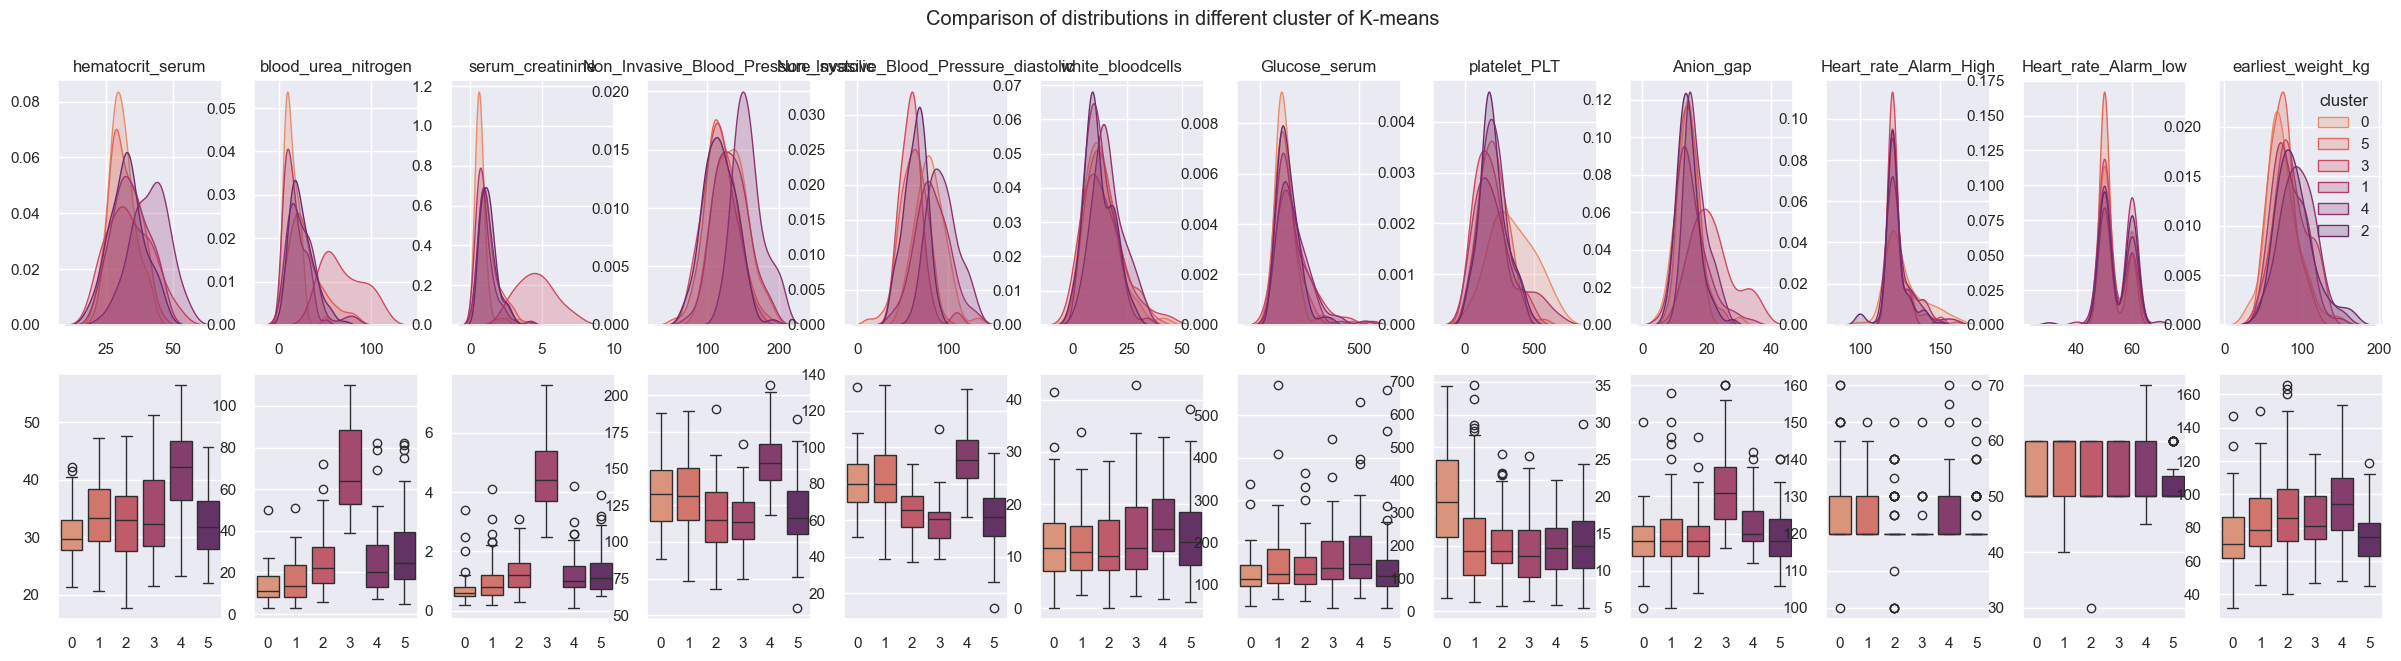

{'hematocrit_serum': 0.13151408043558802,
 'blood_urea_nitrogen': 3.3700772676171266e-08,
 'serum_creatinine': 4.557833667267363e-06,
 'Non_Invasive_Blood_Pressure_systolic': 0.0010800751736933832,
 'Non_Invasive_Blood_Pressure_diastolic': 1.3293134043583379e-10,
 'white_bloodcells': 0.41517348595156767,
 'Glucose_serum': 0.2751435884685053,
 'platelet_PLT': 1.7185986419885576e-08,
 'Anion_gap': 0.14678746171071125,
 'Heart_rate_Alarm_High': 0.026736194416790062,
 'Heart_rate_Alarm_low': 0.10523609154381554,
 'earliest_weight_kg': 0.7914944021331611}

In [217]:
plot_mean_difference(df_clean, 'cluster', "Comparison of distributions in different cluster of K-means", colours=palette, features_kde=features_kde)

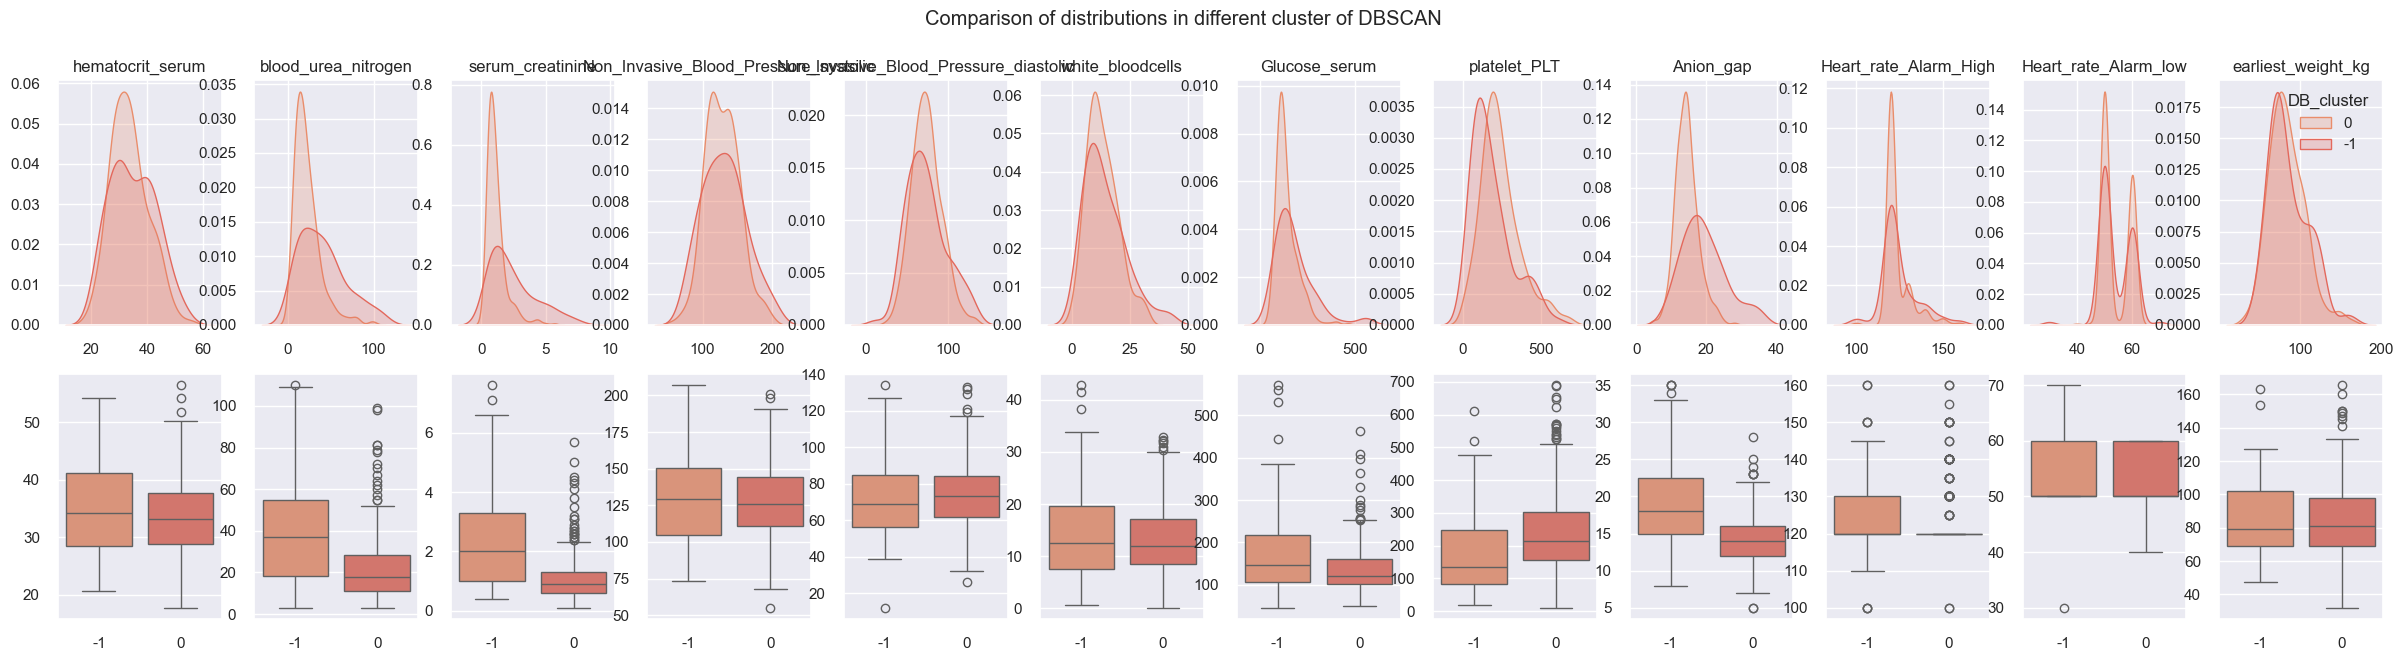

{'hematocrit_serum': 0.12294308428328025,
 'blood_urea_nitrogen': 6.374848573403579e-14,
 'serum_creatinine': 5.673090070256482e-20,
 'Non_Invasive_Blood_Pressure_systolic': 0.43447613715936284,
 'Non_Invasive_Blood_Pressure_diastolic': 0.9215059983598519,
 'white_bloodcells': 0.20099803444018433,
 'Glucose_serum': 6.252507162250179e-06,
 'platelet_PLT': 0.0003879316192331497,
 'Anion_gap': 2.3134575360670938e-20,
 'Heart_rate_Alarm_High': 0.3011941246678758,
 'Heart_rate_Alarm_low': 0.8592226031154342,
 'earliest_weight_kg': 0.49814744528772303}

In [218]:
plot_mean_difference(df_clean, 'DB_cluster', "Comparison of distributions in different cluster of DBSCAN", colours=palette, features_kde=features_kde)

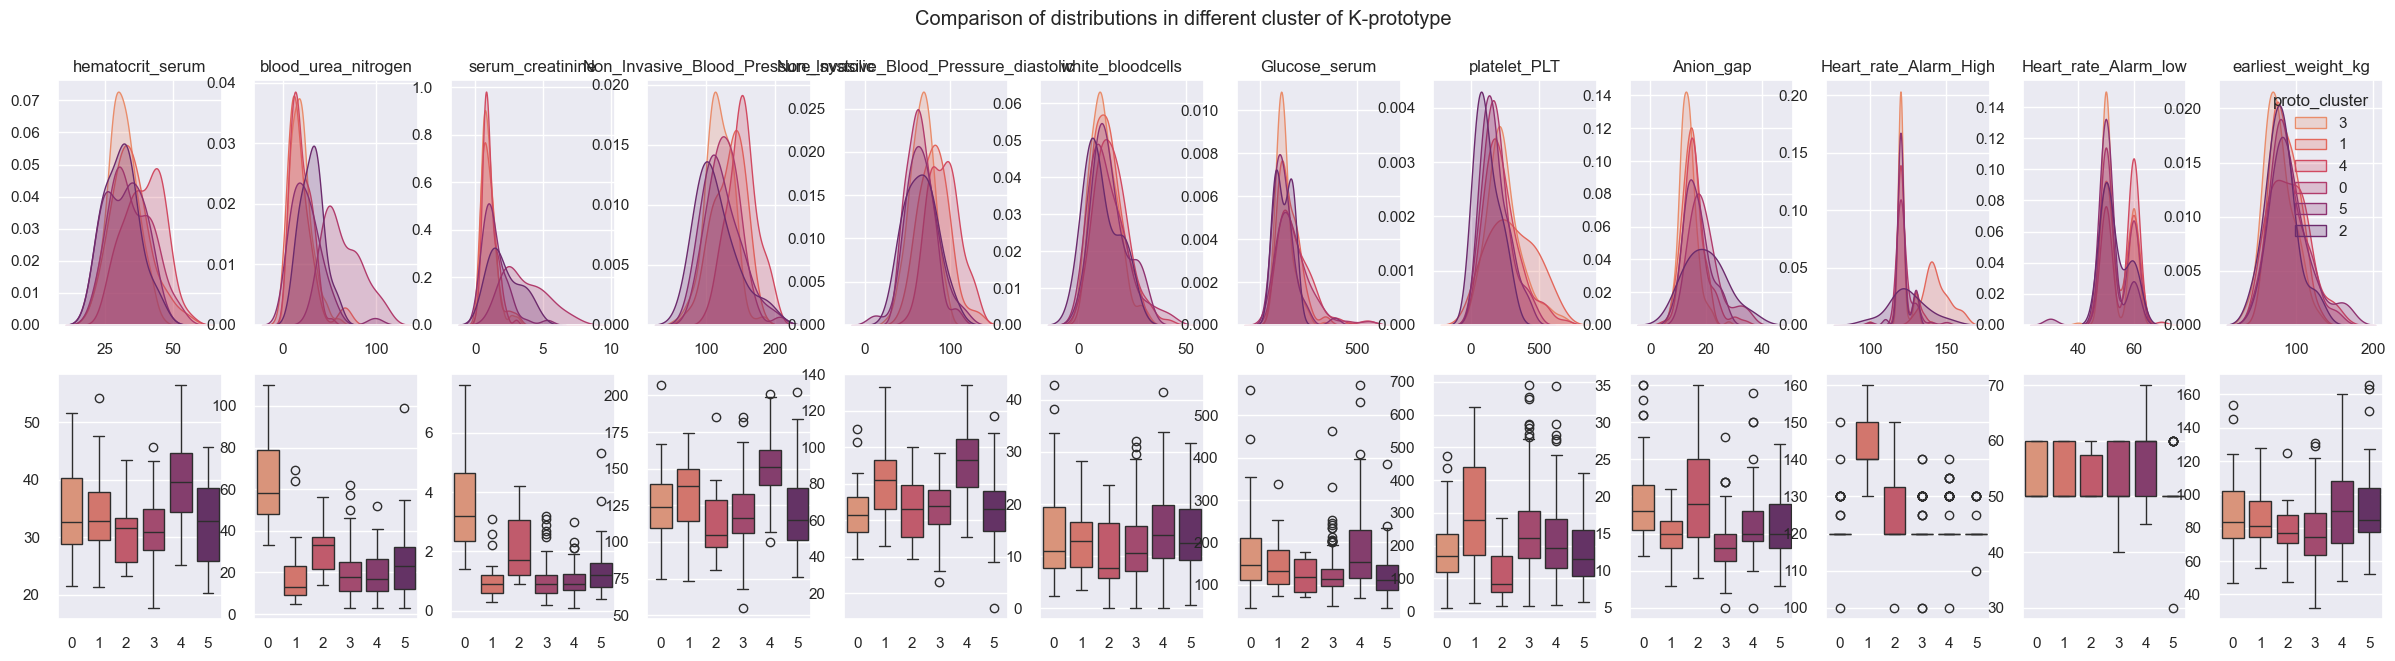

{'hematocrit_serum': 0.006986159900372339,
 'blood_urea_nitrogen': 0.549843787397062,
 'serum_creatinine': 0.8055155977292598,
 'Non_Invasive_Blood_Pressure_systolic': 0.0002719996089134951,
 'Non_Invasive_Blood_Pressure_diastolic': 1.2440782750664182e-07,
 'white_bloodcells': 0.17915244679019285,
 'Glucose_serum': 0.024719359275821196,
 'platelet_PLT': 0.03184586029382499,
 'Anion_gap': 0.028891635633204637,
 'Heart_rate_Alarm_High': 2.760012515419382e-57,
 'Heart_rate_Alarm_low': 0.21773422791717262,
 'earliest_weight_kg': 0.011788290214040336}

In [219]:
plot_mean_difference(df_clean, 'proto_cluster', "Comparison of distributions in different cluster of K-prototype", colours=palette, features_kde=features_kde)

## Mortality rate

In [220]:
def plot_mortality(label):
    mortality_cluster = []
    x_ax = []
    for c in sorted(df_clean[label].unique()):
        sub = df_clean[df_clean[label] == c]
        mortality_cluster.append(100 * len(sub[sub.mortality == 'Dead']) / df_clean.mortality.value_counts()['Dead'])
        x_ax.append(c)

    plt.bar(x_ax, mortality_cluster, color=palette)
    plt.axhline(y=round(100* len(df_clean[df_clean.mortality == 'Dead']) / len(df_clean),2), color='red', linestyle='--', linewidth=2, label='Mortality rate')
    plt.annotate('Overall 19.84%', xy=(0, 20), xytext=(2.5, 21))

    for c, rate in zip(x_ax, mortality_cluster):
        plt.text(c, rate + 1, f'{rate:.2f}%', ha='center', va='bottom')

    plt.xlabel("Cluster")
    plt.ylim([0,100])

def scatter_plot(label):
    for cluster in X_pca[label].unique():
        cluster_data = X_pca[X_pca[label] == cluster]
        plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'cluster {cluster}', color=palette[cluster])
    plt.xlabel('PC1')

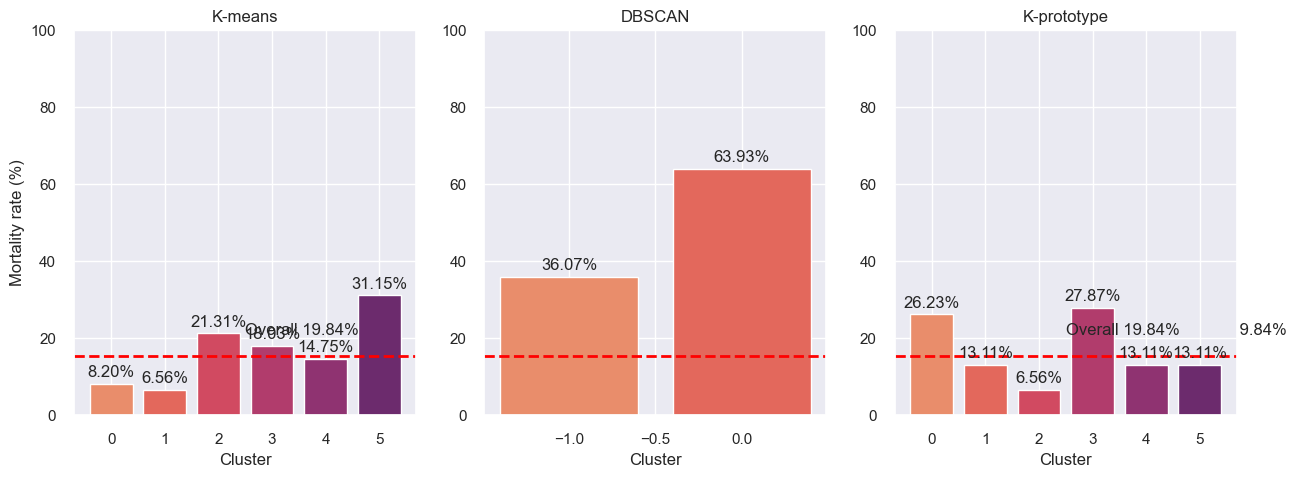

In [221]:
# Mortality rate in each cluster
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plot_mortality('cluster')
plt.ylabel("Mortality rate (%)")
plt.title("K-means")

plt.subplot(1,3,2)
plot_mortality('DB_cluster')
plt.title("DBSCAN")

plt.subplot(1,3,3)
plot_mortality('proto_cluster')
plt.title("K-prototype")

plt.show()

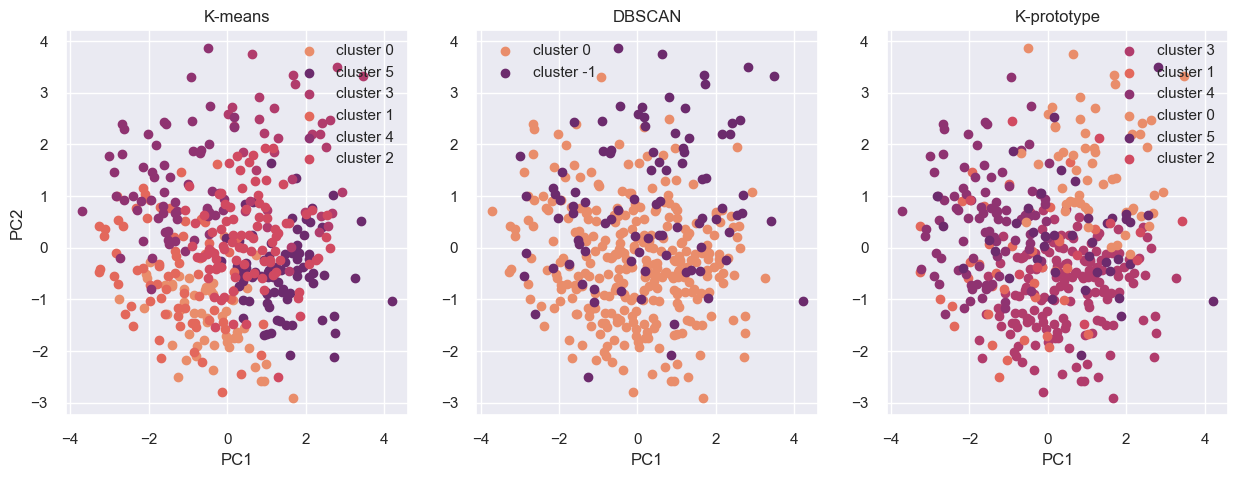

In [222]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
scatter_plot('cluster')
plt.ylabel('PC2')
plt.title("K-means")
plt.legend()

plt.subplot(1,3,2)
scatter_plot('DB_cluster')
plt.title("DBSCAN")
plt.legend()

plt.subplot(1,3,3)
scatter_plot('proto_cluster')
plt.title("K-prototype")
plt.legend()

In [223]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='cluster', title="K-means", color_discrete_sequence=palette)
fig.show()

In [226]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='DB_cluster', title="DBSCAN", color_discrete_sequence=palette)
fig.show()

In [227]:
fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='proto_cluster', title="K-prototype", color_discrete_sequence=palette)
fig.show()